In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import sklearn.preprocessing as pp
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.models import load_model
import h5py

In [2]:
df = pd.read_pickle("train_clean.pkl")

In [3]:
df

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,walkDistance,weaponsAcquired,winPoints,winPlacePerc,total_distance,health_items,headhshot_perc,teamwork,killStreak_len,totalHits
0,0,0,0.00000,0,0,0,60,1241,0,0,...,244.7500,1,1466,0.444336,244.7500,0,0.0,0,0.0,0
1,0,0,91.50000,0,0,0,57,0,0,0,...,1434.0000,5,0,0.640137,1445.0000,0,0.0,0,0.0,0
2,1,0,68.00000,0,0,0,47,0,0,0,...,161.7500,2,0,0.775391,161.7500,0,0.0,1,0.0,0
3,0,0,32.90625,0,0,0,75,0,0,0,...,202.7500,3,0,0.166748,202.7500,0,0.0,0,0.0,0
4,0,0,100.00000,0,0,0,45,0,1,1,...,49.7500,2,0,0.187500,49.7500,0,0.0,0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,0,0,0.00000,0,0,0,74,1029,0,0,...,1019.0000,3,1507,0.178589,2312.0000,0,0.0,0,0.0,0
4446962,0,1,44.15625,0,0,0,69,0,0,0,...,81.6875,6,0,0.293457,81.6875,1,0.0,0,0.0,0
4446963,0,0,59.06250,0,0,0,66,0,0,0,...,788.5000,4,0,0.481445,790.5000,0,0.0,0,0.0,0
4446964,0,4,180.37500,1,1,2,11,0,2,1,...,2748.0000,8,0,0.799805,2748.0000,6,0.5,2,0.5,3


In [4]:
numerical_cols = list(df.columns)
numerical_cols.remove('matchType')
numerical_cols.remove('winPlacePerc')

# numerical_cols = ['assists', 'boosts', 'damageDealt', 'DBNOs',
#                   'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
#                   'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
#                   'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', 
#                   'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
#                   'weaponsAcquired', 'winPoints']

cat_cols = ['matchType']

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=5)

train_inputs = train_df.drop(columns=['winPlacePerc'])
y_train = train_df['winPlacePerc']
valid_inputs = val_df.drop(columns=['winPlacePerc'])
y_valid = val_df['winPlacePerc']

In [5]:
from sklearn.preprocessing import StandardScaler

#creating instance of a StandardScaler
scaler = StandardScaler().fit(train_inputs[numerical_cols])

#scaling the numeric features
train_inputs[numerical_cols] = scaler.transform(train_inputs[numerical_cols])
valid_inputs[numerical_cols] = scaler.transform(valid_inputs[numerical_cols])

from sklearn.preprocessing import OneHotEncoder
#encoding categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(train_inputs[cat_cols])
category_cols = list(encoder.get_feature_names(cat_cols))
train_inputs[category_cols] = encoder.transform(train_inputs[cat_cols])

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(valid_inputs[cat_cols])
category_cols = list(encoder.get_feature_names(cat_cols))
valid_inputs[category_cols] = encoder.transform(valid_inputs[cat_cols])

train_inputs.columns

#including both columns to get the dataframe that we can put through the model
X_train = train_inputs[numerical_cols + category_cols]
X_valid = valid_inputs[numerical_cols + category_cols]

In [6]:
X_train.shape

(3554961, 37)

In [7]:
X_valid.shape

(888741, 37)

In [8]:
def build_model(x_train):
    model = Sequential()
    model.add(Dense(512, kernel_initializer='he_normal', input_dim=x_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(256, kernel_initializer='he_normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(128, kernel_initializer='he_normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    optimizer = keras.optimizers.Adam(lr=0.01, epsilon=1e-8, decay=1e-4, amsgrad=False)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model 

In [9]:
model = build_model(X_train)
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               19456     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                              

2022-05-29 18:12:45.840726: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-29 18:12:45.841739: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
save_best_only=True

In [11]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10, verbose=0):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule, verbose)

lr_sched = step_decay_schedule(initial_lr=0.1, decay_factor=0.9, step_size=1, verbose=1)
early_stopping = EarlyStopping(monitor='val_mae', mode = 'min', patience=4, verbose=1)
#checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
#model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_mae', mode = 'min', save_best_only=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', mode = 'min',factor=0.5, patience=3, min_lr=0.0001, verbose=1)

In [12]:
history = model.fit(X_train, y_train, 
                 validation_data=(X_valid, y_valid),
                 epochs=30,
                 batch_size=32768,
                 callbacks=[lr_sched,early_stopping], 
                 verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 0.1.
Epoch 1/30


2022-05-29 18:12:59.266727: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-29 18:12:59.979305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


109/109 [==============================] - ETA: 0s - loss: 0.0550 - mae: 0.1682

2022-05-29 18:13:32.824352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


109/109 [==============================] - 35s 309ms/step - loss: 0.0550 - mae: 0.1682 - val_loss: 0.2339 - val_mae: 0.4253 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.09000000000000001.
Epoch 2/30
109/109 [==============================] - 27s 236ms/step - loss: 0.0098 - mae: 0.0705 - val_loss: 0.0298 - val_mae: 0.1441 - lr: 0.0900

Epoch 3: LearningRateScheduler setting learning rate to 0.08100000000000002.
Epoch 3/30
109/109 [==============================] - 25s 226ms/step - loss: 0.0079 - mae: 0.0640 - val_loss: 0.0081 - val_mae: 0.0643 - lr: 0.0810

Epoch 4: LearningRateScheduler setting learning rate to 0.0729.
Epoch 4/30
109/109 [==============================] - 28s 252ms/step - loss: 0.0075 - mae: 0.0625 - val_loss: 0.0077 - val_mae: 0.0625 - lr: 0.0729

Epoch 5: LearningRateScheduler setting learning rate to 0.06561.
Epoch 5/30
109/109 [==============================] - 25s 224ms/step - loss: 0.0073 - mae: 0.0615 - val_loss: 0.0076 - val_mae: 0.06

In [13]:
result = model.evaluate(X_valid,y_valid)

27774/27774 [==============================] - 113s 4ms/step - loss: 0.0064 - mae: 0.0570


In [15]:
result = model.evaluate(X_train,y_train)

111093/111093 [==============================] - 456s 4ms/step - loss: 0.0063 - mae: 0.0568


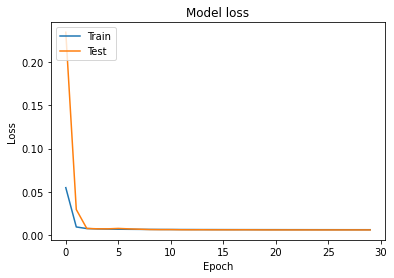

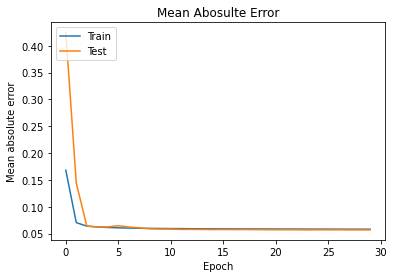

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation mae values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Abosulte Error')
plt.ylabel('Mean absolute error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
def build_model2(x_train):
    model = Sequential()
    model.add(Dense(1024, kernel_initializer='he_normal', input_dim=x_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(512, kernel_initializer='he_normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(256, kernel_initializer='he_normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(128, kernel_initializer='he_normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    optimizer = keras.optimizers.Adam(lr=0.01, epsilon=1e-8, decay=1e-4, amsgrad=False)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model 

In [17]:
model2 = build_model2(X_train)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              38912     
                                                                 
 batch_normalization_3 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 512)              

In [18]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10, verbose=0):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule, verbose)

lr_sched = step_decay_schedule(initial_lr=0.1, decay_factor=0.9, step_size=1, verbose=1)
early_stopping = EarlyStopping(monitor='val_mae', mode = 'min', patience=6, verbose=1)
#checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
#model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_mae', mode = 'min', save_best_only=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', mode = 'min',factor=0.5, patience=3, min_lr=0.0001, verbose=1)

In [21]:
history = model.fit(X_train, y_train, 
                 validation_data=(X_valid, y_valid),
                 epochs=30,
                 batch_size=32768,
                 callbacks=[lr_sched,early_stopping], 
                 verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 0.1.
Epoch 1/30
109/109 [==============================] - 30s 273ms/step - loss: 0.0729 - mae: 0.2120 - val_loss: 0.0838 - val_mae: 0.2381 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.09000000000000001.
Epoch 2/30
109/109 [==============================] - 27s 243ms/step - loss: 0.0783 - mae: 0.2297 - val_loss: 0.0659 - val_mae: 0.2108 - lr: 0.0900

Epoch 3: LearningRateScheduler setting learning rate to 0.08100000000000002.
Epoch 3/30
109/109 [==============================] - 27s 243ms/step - loss: 0.0477 - mae: 0.1661 - val_loss: 0.0773 - val_mae: 0.2337 - lr: 0.0810

Epoch 4: LearningRateScheduler setting learning rate to 0.0729.
Epoch 4/30
109/109 [==============================] - 27s 250ms/step - loss: 0.0089 - mae: 0.0689 - val_loss: 0.0245 - val_mae: 0.1293 - lr: 0.0729

Epoch 5: LearningRateScheduler setting learning rate to 0.06561.
Epoch 5/30
109/109 [==============================] - 26s 2

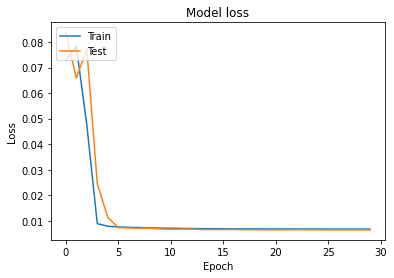

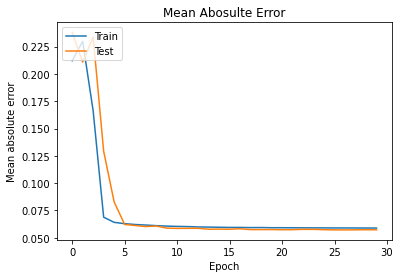

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation mae values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Abosulte Error')
plt.ylabel('Mean absolute error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
model.evaluate(X_valid,y_valid)

27774/27774 [==============================] - 121s 4ms/step - loss: 0.0064 - mae: 0.0573


[0.006416295655071735, 0.05733029171824455]

In [24]:
model.evaluate(X_train,y_train)

111093/111093 [==============================] - 510s 5ms/step - loss: 0.0064 - mae: 0.0572


[0.006379668600857258, 0.05719217658042908]